In [1]:
!pip install pytorch_lightning
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 5.1 MB/s eta 0:00:00


In [2]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR = "/content/drive/MyDrive/recsys-mobod-2022/"

In [5]:
data = pd.read_json(DATA_DIR + "data.json", lines=True)

In [6]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [7]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

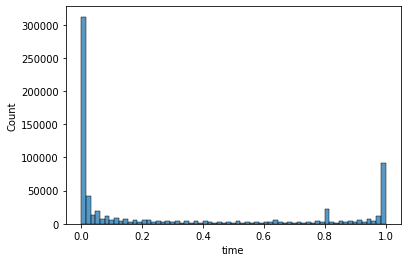

In [8]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [9]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [10]:
train_data.head(5)

,user,start,track,time
0,0,2999,5089,0.0
2,0,2999,7960,0.0
3,0,2999,1725,0.0
4,0,2999,2606,0.0
7,0,31348,2224,0.0


In [14]:
users_size = len(set(pairs["user"].values.tolist()))

In [15]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.user = nn.Embedding(num_embeddings=users_size, embedding_dim=self.embedding_dim)


    def forward(self, x):
        context = self.context(x[:, 0])
        track = self.track(x[:, 1])
        user = self.user(x[:, 2])
        return torch.sum((context + user) * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        avgs = y[:, 0].float()
        targets = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [16]:
class ContextualRankerData(pl.LightningDataModule):
  def __init__(self, train_data, val_data, test_data, features):
      super().__init__()
      self.train_data = train_data
      self.val_data = val_data
      self.test_data = test_data
      self.features = features

  def prepare_data(self):
      self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

  def setup(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values), 
            torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )
        
      if stage == "test" or stage is None:  
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [17]:
net = ContextualRanker(embedding_dim=100)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", "user"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [18]:
trainer.fit(
    net, 
    data_module
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 5.0 M 
1 | track   | Embedding | 5.0 M 
2 | user    | Embedding | 1.0 M 
--------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
44.000    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00139: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00154: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00158: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

In [19]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [20]:
trainer.test(best, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.15447917580604553    │
│         rdm_loss          │    0.12324310839176178    │
│         test_loss         │    0.07193301618099213    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07193301618099213,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.12324310839176178}]

## Save results

In [21]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()
user_embeddings = dict(best.named_parameters())["user.weight"].data.cpu().numpy()

In [22]:
np.save(os.path.join(DATA_DIR, "context_embeddings.npy"), context_embeddings)
np.save(os.path.join(DATA_DIR, "user_embeddings.npy"), user_embeddings)
np.save(os.path.join(DATA_DIR, "track_embeddings.npy"), track_embeddings)